In [11]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt

# Draw a time domain graph
def plot_time(signal, sample_rate):
    time = np.arange(0, len(signal)) * (1.0 / sample_rate)
    plt.figure(figsize=(20, 5))
    plt.plot(time, signal)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.grid()
# Draw the frequency domain
def plot_freq(signal, sample_rate, fft_size=512):
    xf = np.fft.rfft(signal, fft_size) / fft_size
    freqs = np.linspace(0, sample_rate/2, fft_size/2 + 1)
    xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
    plt.figure(figsize=(20, 5))
    plt.plot(freqs, xfp)
    plt.xlabel('Freq(hz)')
    plt.ylabel('dB')
    plt.grid()
# Draw the spectrum
def plot_spectrogram(spec, note):
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(note)
    plt.tight_layout()


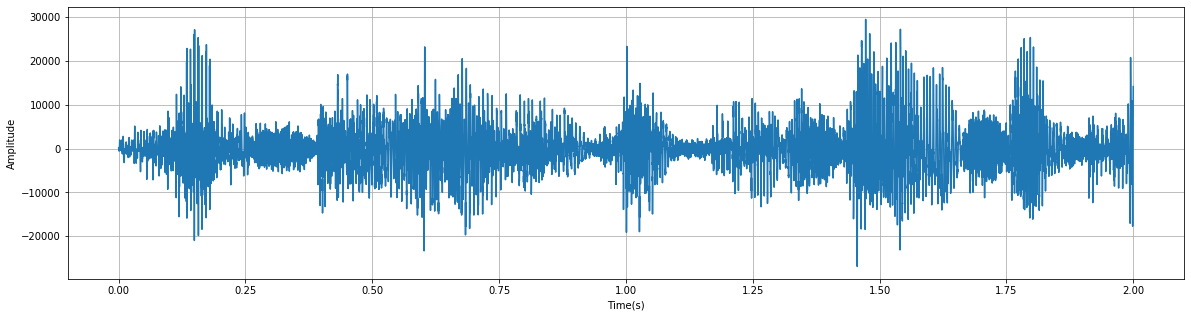

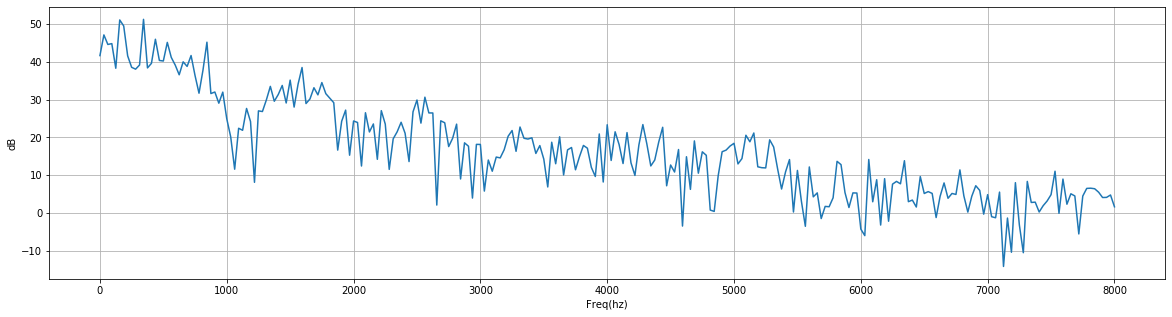

In [12]:
sample_rate, signal = scipy.io.wavfile.read('1.wav')
plot_time(signal, sample_rate)
plot_freq(signal, sample_rate)

### First order difference
In order to make the high frequency signal more average, 
we can see from the above frequency domain spectrum that the amplitude in the high frequency part is relatively small.

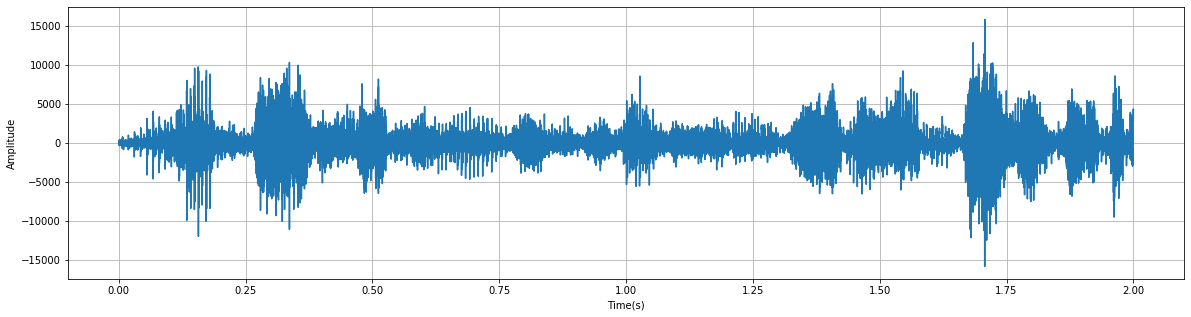

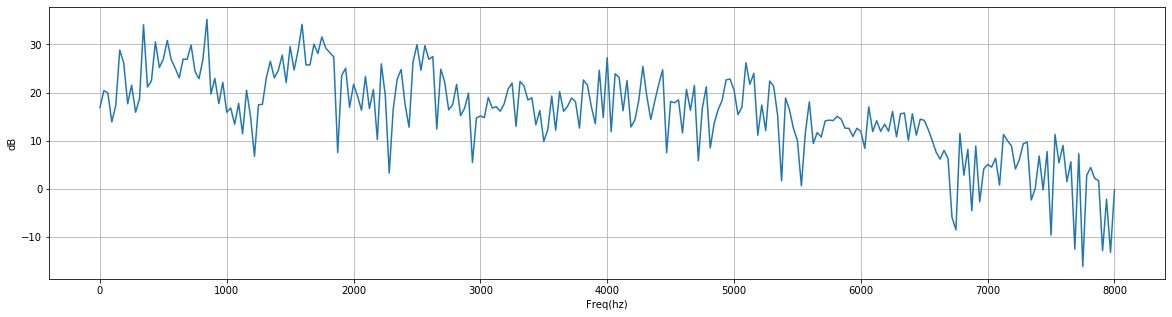

In [13]:
emphasized_signal = np.append(signal[0], signal[1:] - 0.97*signal[:-1])
plot_time(emphasized_signal, sample_rate)
plot_freq(emphasized_signal, sample_rate)

### Calculate 
做短时傅里叶变换前的分帧操作(窗长：25ms，窗移：10ms)

In [22]:
frame_length, frame_stride = sample_rate * 0.025, sample_rate * 0.01
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_stride = int(round(frame_stride))
num_frames = int(np.ceil(float(np.abs(signal_length-frame_length)/frame_stride)))

pad_signal_length = num_frames * frame_stride + frame_length
z = np.zeros((pad_signal_length-signal_length))
pad_signal = np.append(emphasized_signal, z)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.arange(0, num_frames * frame_stride, frame_stride).reshape(-1, 1)
frames = pad_signal[indices.astype(np.int32, copy=False)]

### Windows

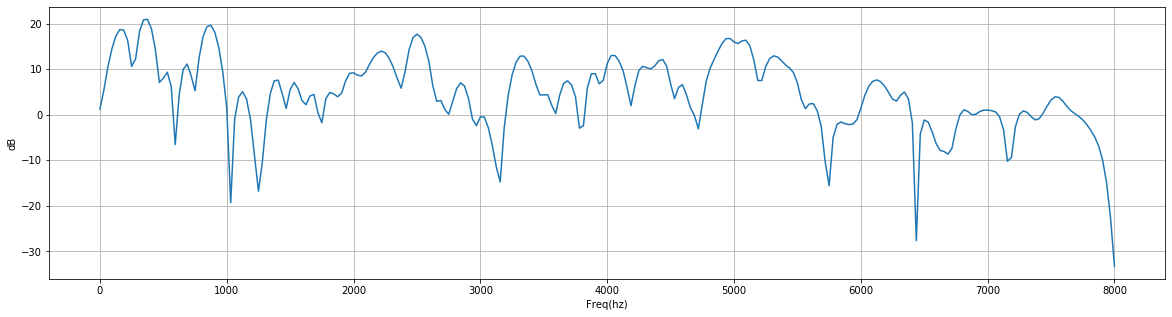

In [28]:
frames *= np.hamming(frame_length)
plot_freq(frames[0], sample_rate)

### Fast Fourier Transform（FFT）

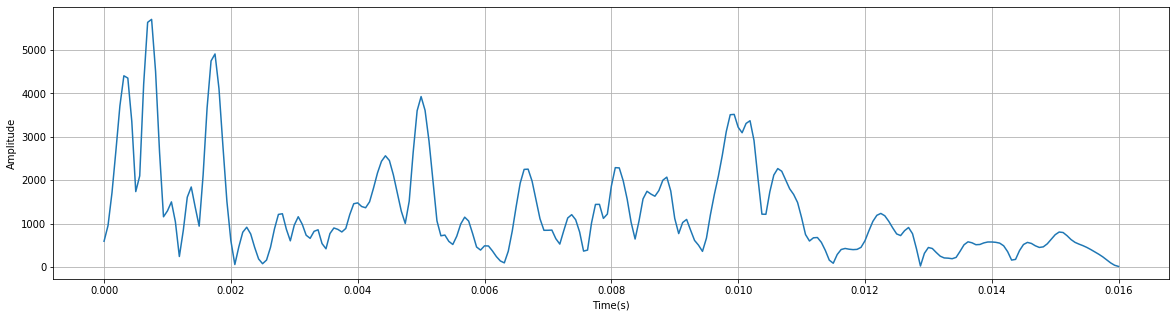

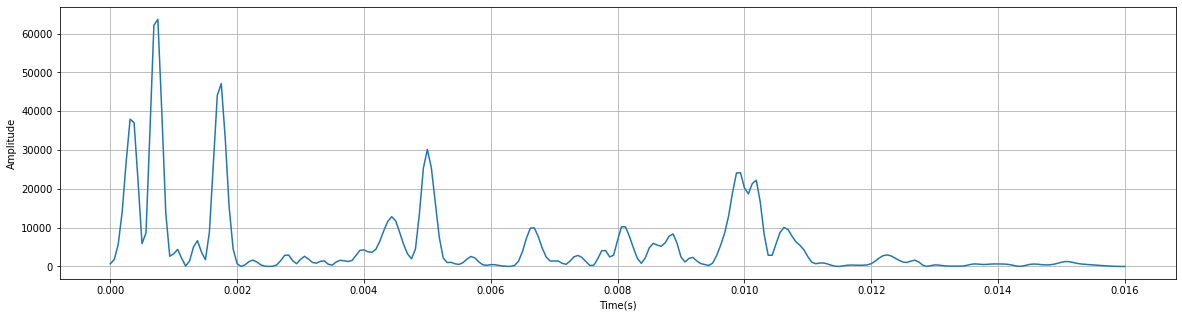

In [32]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
plot_time(mag_frames[0], sample_rate)
plot_time(pow_frames[0], sample_rate)

### Filter Banks
using mel-scale

$$m=2595\log_{10}\left(1+\frac f{700}\right)$$
$$f=700(10^{m/2595}-1)$$

In [48]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate/2)/700)) # Generally half of the sampling rate.
mel_point = np.linspace(low_freq_mel, high_freq_mel, 42) # Equally spaced in Mel scale, 42 is filters number
hz_points = 700*(np.power(10, mel_point/2595)-1)
bin = np.floor((NFFT) * hz_points / sample_rate)
bin

array([  0.,   1.,   2.,   4.,   6.,   8.,   9.,  12.,  14.,  16.,  19.,
        21.,  24.,  27.,  30.,  33.,  37.,  41.,  45.,  49.,  54.,  59.,
        64.,  69.,  75.,  81.,  88.,  95., 102., 110., 119., 128., 137.,
       147., 158., 170., 182., 195., 209., 223., 239., 256.])

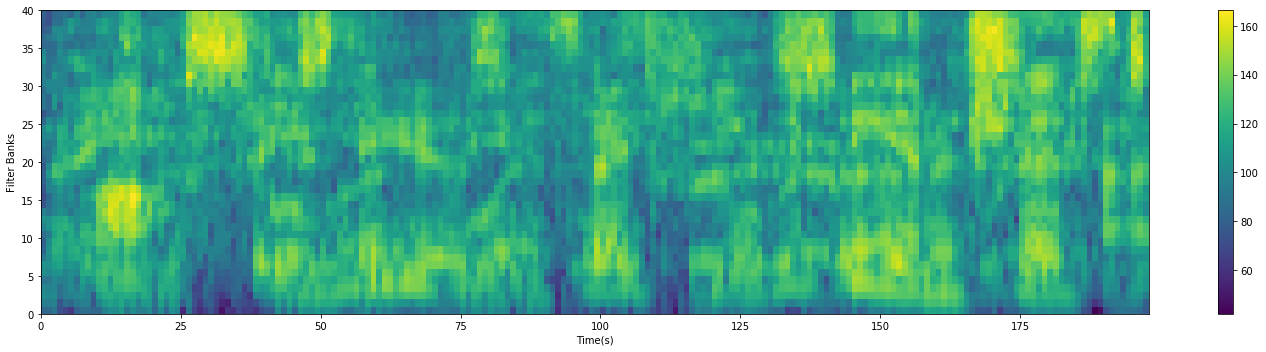

In [52]:
fbank = np.zeros((40, int(np.floor(NFFT/2+1))))
for m in range(1, 40+1):
    f_m_left = int(bin[m-1])
    f_m_center = int(bin[m])
    f_m_right = int(bin[m+1])
    for k in range(f_m_left, f_m_center):
        fbank[m-1, k+1] = (k+1 - bin[m-1])/(bin[m] - bin[m-1])
    for k in range(f_m_center, f_m_right):
        fbank[m-1, k+1] = (bin[m+1] - k+1)/(bin[m+1] - bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)
plot_spectrogram(filter_banks.T, 'Filter Banks')